In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from skimage import io
from skimage import transform
import tensorflow as tf
import utils

%matplotlib inline

In [3]:
pics_train, labels_train, pics_test, labels_test = utils.load_mnist()

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
print("Training data:")
print(pics_train.shape)
print(labels_train.shape)
print()
print("Test data:")
print(pics_test.shape)
print(labels_test.shape)

Training data:
(55000, 28, 28, 1)
(55000, 10)

Test data:
(10000, 28, 28, 1)
(10000, 10)


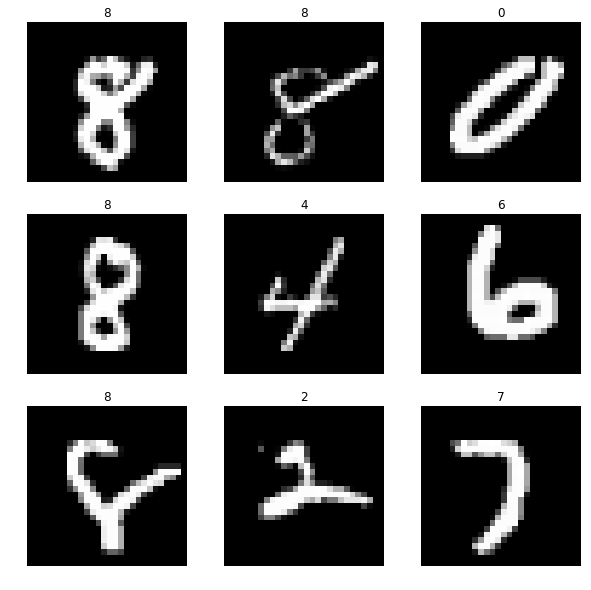

In [5]:
utils.show_random_mnist(pics_train, labels_train)

In [6]:
print(np.unique(pics_train[0]))

[0.         0.01568628 0.01960784 0.0509804  0.07058824 0.08235294
 0.09019608 0.09803922 0.12156864 0.13333334 0.14509805 0.14901961
 0.16078432 0.18823531 0.20000002 0.22352943 0.2392157  0.24313727
 0.26666668 0.27058825 0.29411766 0.3019608  0.32156864 0.32941177
 0.3372549  0.34901962 0.3529412  0.37647063 0.3803922  0.4156863
 0.4431373  0.45098042 0.45882356 0.46274513 0.4666667  0.48627454
 0.5019608  0.5411765  0.54509807 0.54901963 0.5568628  0.6156863
 0.6509804  0.65882355 0.6627451  0.6901961  0.73333335 0.7411765
 0.74509805 0.7803922  0.7843138  0.8078432  0.81568635 0.8235295
 0.8352942  0.8431373  0.8588236  0.86274517 0.8705883  0.8745099
 0.8862746  0.89019614 0.8941177  0.9058824  0.9176471  0.9215687
 0.9333334  0.93725497 0.94117653 0.9450981  0.9490197  0.95294124
 0.9607844  0.96470594 0.9725491  0.9803922  0.9843138  0.9921569
 0.9960785 ]


## Defining model

In [7]:
N, H, W, _ = pics_train.shape
F = H * W
NUM_CLASSES = 10

In [26]:
def load_architecture():
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, shape=[None, H, W, 1], name="x")
    y = tf.placeholder(tf.uint8, shape=[None, NUM_CLASSES], name="y")
    
    init = tf.contrib.layers.xavier_initializer()
    
    out = tf.contrib.layers.flatten(x)

    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=NUM_CLASSES, kernel_initializer=init, name="out")
    
    return x, y, out

In [27]:
def load_loss(y, out):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out, name="mean_loss")
    loss = tf.reduce_mean(loss, name="loss")
    return loss

In [28]:
def load_accuracy(y, out):
    pred = tf.argmax(out, axis=-1)
    gt = tf.argmax(y, axis=-1)
    
    matches = tf.equal(pred, gt)
    
    return tf.reduce_mean(tf.cast(matches, tf.float32), name="acc")

In [29]:
def load_trainer(loss):
    opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    return opt.minimize(loss)

In [30]:
def register_scalars(m):
    for k, v in m.items():
        tf.summary.scalar(k, v)

In [31]:
def register_images(m):
    for k, v in m.items():
        tf.summary.image(k, v)

In [32]:
def trainable_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

In [33]:
def load_model():
    x, y, out = load_architecture()
    loss = load_loss(y, out)
    acc = load_accuracy(y, out)
    upd = load_trainer(loss)
    
    register_scalars({"info_loss": loss, "info_acc": acc})
    register_images({"input": x})

    info = tf.summary.merge_all()
    
    return x, y, out, loss, acc, upd, info

# Train model

In [34]:
def load_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess

In [35]:
def train(sess, model, pics_train, labels_train, pics_val, labels_val, epochs, batch_size, train_writer, val_writer):
    N, _, _, _ = pics_train.shape
    idxs = np.arange(N)
    
    x, y, out, loss, acc, upd, info = model
        
    i=0

    for ep in tqdm(range(epochs)):
        np.random.shuffle(idxs)
        pics_train = pics_train[idxs]
        labels_train = labels_train[idxs]

        for b in range(0, N, batch_size):
            X_batch = pics_train[b:b+batch_size]
            Y_batch = labels_train[b:b+batch_size]

            if X_batch.shape[0] < BATCH_SIZE:
                break

            graph_info, _ = sess.run([info, upd], feed_dict={x: X_batch, y: Y_batch})
            train_writer.add_summary(graph_info, i)
            
            graph_info, = sess.run([info], feed_dict={x: pics_val, y: labels_val})
            val_writer.add_summary(graph_info, i)
            
            i+=1

In [36]:
def predict(imgs, model):
    x, y, out, loss, acc, upd, info = model

    N, H, W, _ = imgs.shape
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        idx = np.random.choice(range(N)) 
        img = imgs[idx].reshape((1, H, W, 1))
        graph_out, = sess.run([out], feed_dict={x: img})
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.squeeze(img), cmap="gray")
        plt.title(np.argmax(np.squeeze(graph_out)))
    plt.show()

### Train on full data

In [37]:
model = load_model()
sess = load_session()
print("Trainable parameters: {}".format(trainable_parameters()))

Trainable parameters: 335114


In [38]:
EPOCHS = 70
BATCH_SIZE = 64
LOGS_DIR = "logs"

t_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all", "train"), graph=sess.graph)
v_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all", "val"), graph=sess.graph)

train(sess, model, pics_train, labels_train, pics_test, labels_test, EPOCHS, BATCH_SIZE, t_writer, v_writer)


  4%|▍         | 3/70 [05:16<1:57:57, 105.64s/it]

KeyboardInterrupt: 

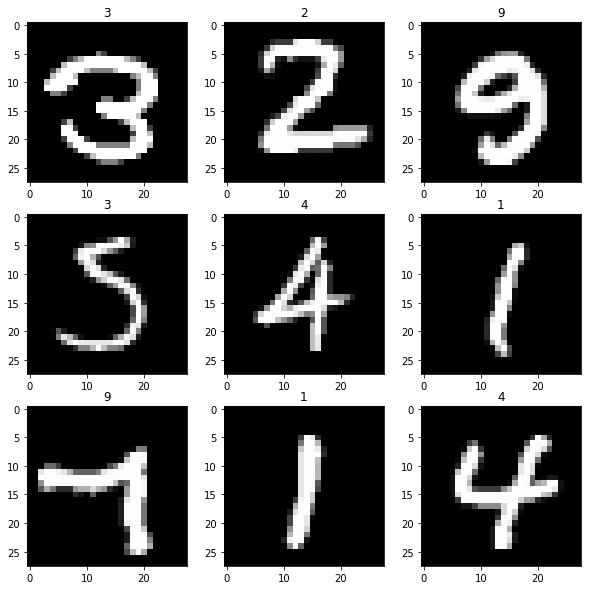

In [21]:
predict(pics_train, model)

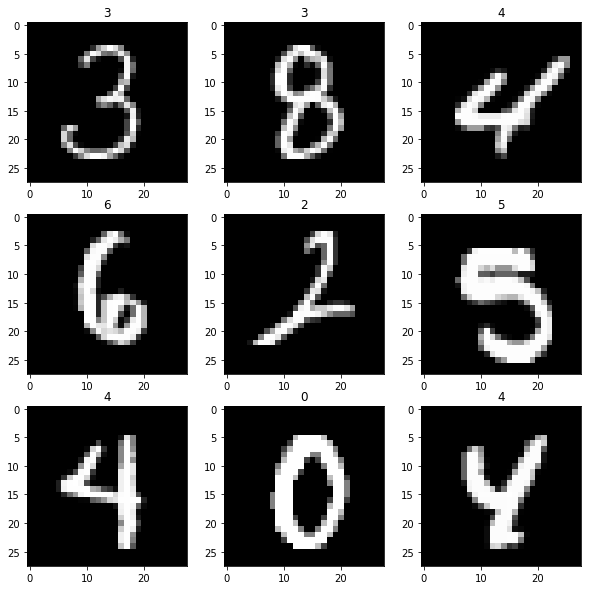

In [40]:
predict(pics_test, model)

In [39]:
saver = tf.train.Saver()
saver.save(sess, "trained_models/mnist/model.ckpt")

'trained_models/mnist/model.ckpt'